<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter5_multilayer_multizone_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

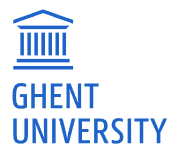<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 5: Simulating Multilayer-Multizone Flow**

This Jupyter notebook implements the generalized semi-analytical solution method for simulating axisymmetric and parallel multilayer-multizone flow developed in chapter 5 of my PhD thesis (Louwyck, 2023), and the finite-difference method discussed in chapter 3 and presented by Louwyck et al. (2012). Both solution methods are compared with each other. The notebook also implements several well-known solutions presented in the hydrogeological literature and used to verify the generalized semi-analytical solution method.

## Solutions

Import the required packages, modules, and functions.

In [ ]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import warnings
import scipy
from scipy.linalg import eig, inv, solve, LinAlgWarning, LinAlgError
from scipy.special import i0, k0, i1, k1, exp1
from math import factorial, log

Check versions:

In [ ]:
# print("NumPy", np.__version__)
# print("Matplotlib", matplotlib.__version__)
# print("SciPy", scipy.__version__)

### Stehfest algorithm

Function `stehfest` implements the Stehfest (1970) algorithm:

In [ ]:
def stehfest(F, t, ns=12):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W = stehfest_weights(ns)
    f = np.zeros(nt)
    for k in range(ns):
        p = ln2t * (k + 1)
        f += W[k] * F(p)
    return f * ln2t

def stehfest_weights(ns):
    """
    Calculate weights required for applying the Stehfest algorithm.

    Parameters
    ----------
    ns : int
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    W : ndarray
      One-dimensional array with weights, length of `W` is equal to `ns`.
    """
    fac = lambda x: float(factorial(x))
    ns2 = ns // 2
    W = np.zeros(ns)
    for j in range(1, ns + 1):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        for k in range(k_0, m + 1):
            W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(2 * k - j)
        W[j - 1] *= (-1) ** (ns2 + j)
    return W

### Generalized semi-analytical solution

Class to simulate steady-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [ ]:
class Steady:
    """
    Class to simulate steady-state radial or parallel multilayer-multizone flow.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Constant heads [L]. The shape of `h0` is `(nl+2, nz)`.
       Note that only `h0[0, :]`, `h0[-1, :]`, and `h0[:, -1]` are relevant for steady-state flow.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qh(r) :
          Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L].
    """

    def __init__(self, R, T, c, Q=None, H=None, N=None, h0=None, axi=True):
        self.R = np.array(R)
        self.T = np.array(T)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.axi = axi
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self._initialized = False
        self.eps = 1e-16
        self.use_scipy_solver = True
        self.no_warnings = True

    def _ini_(self):
        if not self._initialized:
            self._Ab_()
            self._eig_()
            if self.axi:
                self._IKm_axi_()
                self._XYz_axi_()
            else:
                self._IKm_par_()
                self._XYz_par_()
            self._alpha_beta_()
            self._initialized = True

    def _Ab_(self):
        self._A = np.zeros((self.nz, self.nl, self.nl))  # (nz, nl, nl)
        self._b = np.zeros((self.nz, self.nl))  # (nz, nl)
        for k in range(self.nz):
            Tc0 = 1 / (self.T[:, k] * self.c[:-1, k])  # (nl, )
            Tc1 = 1 / (self.T[:, k] * self.c[1:, k])  # (nl, )
            self._idx = np.diag_indices(self.nl)
            irow, icol = self._idx
            A = np.zeros((self.nl, self.nl))  # (nl, nl)
            A[irow, icol] = Tc0 + Tc1
            A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
            A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
            self._A[k] = A
            b = self.N[:, k] / self.T[:, k]  # (nl, )
            b[0] += Tc0[0] * self.h0[0, k]
            b[-1] += Tc1[-1] * self.h0[-1, k]
            self._b[k] = b

    def _eig_(self):
        self._d = np.zeros((self.nz, self.nl))
        self._V = np.zeros((self.nz, self.nl, self.nl))
        self._iV = np.zeros((self.nz, self.nl, self.nl))
        self._v = np.zeros((self.nz, self.nl))
        self._inz = []
        self._iz = []
        self._sd = []
        for k in range(self.nz):
            d, V = eig(self._A[k])  # (nl, ), (nl, nl)
            d = np.real(d)
            inz = np.arange(self.nl)
            if self.confined[k]:
                iz = np.argmin(np.abs(d))
                inz = np.setdiff1d(inz, iz)
            else:
                iz = []
            if len(inz) > 0:
                sd = np.sqrt(d[inz])
            else:
                sd = []
            iV = inv(V)
            self._d[k] = d
            self._V[k] = V
            self._iV[k] = iV
            self._inz.append(inz)
            self._iz.append(iz)
            self._sd.append(sd)
            self._v[k] = np.dot(iV, self._b[k])

    def _IKm_axi_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = np.log(self.R[k]), np.log(self.R[k+1])
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 4
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 4
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = i0(x1), i0(x2)
                I1[np.isnan(I1)] = np.inf  # i0(inf) = inf
                I2[np.isnan(I2)] = np.inf  # i0(inf) = inf
                K1[inz], K2[inz] = k0(x1), k0(x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _IKm_par_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = self.R[k], self.R[k+1]
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = np.exp(x1), np.exp(x2)
                K1[inz], K2[inz] = np.exp(-x1), np.exp(-x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _XYz_axi_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = x1 * i1(x1), x2 * i1(x2)
                X1[np.isnan(X1)] = np.inf  # inf*i1(inf) = inf
                X2[np.isnan(X2)] = np.inf  # inf*i1(inf) = inf
                Y1[inz], Y2[inz] = -x1 * k1(x1), -x2 * k1(x2)
                b1, b2 = np.isnan(Y1), np.isnan(Y2)
                if np.any(b1):
                    if np.all(x1[b1[inz]] < 1):
                        Y1[b1] = -1.0  # 0*k1(0) = 1
                    else:
                        Y1[b1] = 0.0  # inf*k1(inf) = 0
                if np.any(b2):
                    if np.all(x2[b2[inz]] < 1):
                        Y2[b2] = -1.0  # 0*k1(0) = 1
                    else:
                        Y2[b2] = 0.0  # inf*k1(inf) = 0
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _XYz_par_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = self._sd[k] * np.exp(x1), self._sd[k] * np.exp(x2)
                Y1[inz], Y2[inz] = -self._sd[k] * np.exp(-x1), -self._sd[k] * np.exp(-x2)
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _alpha_beta_(self):
        self._alpha = np.zeros((self.nz, self.nl))
        self._beta = np.zeros((self.nz, self.nl))
        if self.use_scipy_solver:
            ab = self.__scipy_solver__()
            i = np.arange(0, 2) * self.nl
            for k in range(self.nz):
                self._beta[k] = ab[i[0]:i[1]]
                i += self.nl
                self._alpha[k] = ab[i[0]:i[1]]
                i += self.nl
            self._alpha[(np.abs(self._alpha) < self.eps) | np.isnan(self._alpha)] = 0.0
            self._beta[(np.abs(self._beta) < self.eps) | np.isnan(self._beta)] = 0.0
        else:
            self.__solver__()

    def __solver__(self):
        '''apply custom algorithm to find alpha and beta'''
        # check infinite values at boundaries between zones
        nz = 0
        stop = False
        while (nz < self.nz) and not stop:
            stop = np.any(np.isinf(self._I1[nz]) | np.isinf(self._X1[nz])) & \
                   np.any(np.isinf(self._I2[nz]) | np.isinf(self._X2[nz]))
            if not stop: nz += 1
        # forward
        ini = lambda: [[] for _ in range(nz)]
        F, G, H, dG, dH = ini(), ini(), ini(), ini(), ini()
        if self.Q is not None:
            A = inv(self._Y1[0], check_finite=False)
            dG[0] = np.dot(A, self._X1[0])
            dH[0] = -np.dot(A, self._z1[0] + self.Q)
        else:
            A = inv(self._K1[0], check_finite=False)
            dG[0] = np.dot(A, self._I1[0])
            dH[0] = -np.dot(A, self._m1[0] - self.H)
        for k in range(nz - 1):
            j = k + 1
            A = inv(self._K2[k], check_finite=False)
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            F[k] = -mdot((L, A, self._K1[j]))
            G[k] = -mdot((L, A, self._I1[j]))
            H[k] = np.dot(L, np.dot(A, self._m1[j] - self._m2[k]) - dH[k])
            A = inv(self._Y2[k], check_finite=False)
            dL = inv(np.dot(A, self._X2[k]) - dG[k], check_finite=False)
            dF = inv(-mdot((dL, A, self._Y1[j])) - F[k], check_finite=False)
            dG[j] = -np.dot(dF, mdot((dL, A, self._X1[j])) + G[k])
            dH[j] = np.dot(dF, np.dot(dL, np.dot(A, self._z1[j] - self._z2[k]) - dH[k]) - H[k])
        k = nz - 1
        try:
            A = inv(self._K2[k], check_finite=False)  # not invertible if R[nz] -> inf
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            H[k] = np.dot(L, np.dot(A, (self.h0[1:-1, k] - self._m2[k])) - dH[k])
        except LinAlgError:
            H[k] = np.zeros(self.nl)
        # backward
        self._alpha[k] = H[k]
        self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        for k in range(nz - 2, -1, -1):
            j = k + 1
            self._beta[j] = dH[j] - np.dot(dG[j], self._alpha[j])
            self._beta[k][np.isnan(self._beta[k])] = 0.0
            self._alpha[k] = H[k] - np.dot(F[k], self._beta[j]) - np.dot(G[k], self._alpha[j])
            self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        self._beta[0] = dH[0] - np.dot(dG[0], self._alpha[0])
        self._beta[0][np.isnan(self._beta[0])] = 0.0

    def __scipy_solver__(self):
        '''apply scipy solve function to find alpha and beta'''
        n = 2 * self.nl * self.nz
        M = np.zeros((n, n))
        rhs = np.zeros(n)
        # k = 0
        i = np.arange(0, 2) * self.nl
        j = np.arange(-2, 3) * self.nl
        if self.Q is not None:
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[0]
            rhs[i[0]:i[1]] = self._z1[0] + self.Q
        else:
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[0]
            rhs[i[0]:i[1]] = self._m1[0] - self.H
        # 0 < k < nz-1
        for k in range(1, self.nz):
            i += self.nl
            j += 2 * self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._K2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._I2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[k]
            rhs[i[0]:i[1]] = self._m1[k] - self._m2[k-1]
            i += self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._Y2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._X2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[k]
            rhs[i[0]:i[1]] = self._z1[k] - self._z2[k-1]
        # k = nz - 1
        k = self.nz - 1
        i += self.nl
        M[i[0]:i[1], j[2]:j[3]] = self._K2[k]
        M[i[0]:i[1], j[3]:j[4]] = self._I2[k]
        rhs[i[0]:i[1]] = self.h0[1:-1, k] - self._m2[k]
        self._M3, self._rhs3, self._until = self.__check_M__(M.copy(), rhs.copy())
        ab = np.zeros(len(rhs))
        ab[:self._until] = solve(self._M3, self._rhs3, check_finite=False)
        self._M, self._rhs = M.copy(), rhs.copy()
        M, rhs = self.__check_inf__(M, rhs)
        M, rhs = self.__check_zero_columns__(M, rhs)
        self._M2, self._rhs2 = M, rhs
        return ab

    def __check_M__(self, M, rhs):
        # check inf
        b = np.isinf(M)
        if np.any(b):
            irow, icol = np.where(b)
            until = np.min([np.min(irow), np.min(icol)])
            return M[:until, :until], rhs[:until], until
        else:
            return M, rhs, None

    def __check_zero_columns__(self, M, rhs):
        for i in np.where(np.all(M == 0, axis=0)):
            M[i, :] = 0
            M[i, i] = 1
            rhs[i] = 0
        return M, rhs

    def __check_inf__(self, M, rhs):
        b = np.any(np.isinf(M), axis=0)
        if np.any(b):
            i = np.min(np.where(b))
            M[i:, :] = 0
            M[i:, i:] = np.eye(len(M) - i)
            M[:i, i:] = 0
            rhs[i:] = 0
        return M, rhs

    def h(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            h = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], K[iz], m[iz] = np.log(r[j]), 1.0, -self._v[k][iz] * r[j]**2 / 4
                    else:
                        I[iz], K[iz], m[iz] = r[j], 1.0, -self._v[k][iz] * r[j]**2 / 2
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz], m[inz] = i0(x), k0(x), self._v[k][inz] / self._d[k][inz]
                    else:
                        I[inz], K[inz], m[inz] = np.exp(x), np.exp(-x), self._v[k][inz] / self._d[k][inz]
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I0 = Inf
                g = Ia + K * self._beta[k] + m
                h[:, j] = np.dot(self._V[k], g)
            return h

    def qr(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            qr = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]**2 / 2
                    else:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz] = x * i1(x), -x * k1(x)
                        K[np.isnan(K)] = 1.0  # r -> 0: x_in * k1(x_in) = 1
                    else:
                        I[inz], K[inz] = self._sd[k] * np.exp(x), -self._sd[k] * np.exp(-x)
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I1 = Inf
                dg = Ia + K * self._beta[k] + m
                TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
                qr[:, j] = np.dot(TV, dg)
            return qr

Class to simulate transient-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [ ]:
class Transient:
    """
    Class to simulate transient-state radial or parallel multilayer-multizone flow.
    The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    S : array_like
      Storativities [-]. The shape of `S` is `(nl, nz)`.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Initial heads [L]. The shape of `h0` is `(nl+2, nz)`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.
    ns : int, default: `12`
       Number of Stehfest parameters

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, R, T, S, c, Q=None, H=None, N=None, h0=None, axi=True, ns=12):
        self.R = np.array(R)
        self.T = np.array(T)
        self.S = np.array(S)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self.axi = axi
        self.ns = int(ns)
        self._W = stehfest_weights(self.ns)
        self.use_scipy_solver = True
        self.eps = 1e-16
        self.no_warnings = True

    def h(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            h = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    h[:, :, i] += self._W[j] * m.h(r)
                h[:, :, i] *= ln2t
            return h

    def qr(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            qr = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    qr[:, :, i] += self._W[j] * m.qr(r)
                qr[:, :, i] *= ln2t
            return qr

### Finite-difference solution

Class to numerically simulate two-dimensional radial or parallel flow (Louwyck et al., 2012):

In [ ]:
class Numerical:
    """
    Class to simulate radial or parallel flow by applying the finite-difference method.

    Parameters
    ----------
    rb : array_like
       Distances [L] of cell boundaries. The length of `rb` is `nr+1` with `nr` the number of distances.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nr)` with `nl` the number of layers.
    c : array_like, default: `None`
      Vertical resistances [T]. The shape of `c` is `(nl-1, nr)`.
    t : array_like, default: `None`
      Simulation times [T]. The length of `t` is `nt`.
    S : array_like, default: `None`
      Storativities [-]. The shape of `S` is `(nl, nr)`.
    Q : array_like, default: `None`
      Discharges [L³/T] . The shape of `Q` is `(nl, nr)`.
    h0 : array_like, default: `None`
       Initial or constant heads [L]. The shape of `h0` is `(nl, nr)`.
    constant : array_like, default: `None`
             Boolean matrix indicating for each cell whether it has a constant head (`True`) or not (`False`).
             The shape of `constant` is `(nl, nr)`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int (read-only)
       Number of layers
    nr : int (read-only)
       Number of distances (columns)
    steady : bool (read-only)
           If `True`, the simulation is steady-state, otherwise it is transient-state
    r : array (read-only)
      Distances [L] at which the heads are simulated. The length of `r` is `nr`.
    h: array (read-only)
     Simulated heads [L] in each layer at distances `r` and times `t`. The shape of `h` is `(nl, nr, nt)`.
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Methods
    -------
    solve() :
            Simulate the model by solving the system of finite-difference equations.
    """

    def __init__(self, rb, T, c=None, t=None, S=None, Q=None, h0=None, constant=None, axi=True):
        self.rb = np.array(rb, dtype=float)
        self.T = np.array(T, dtype=float)
        self.nl, self.nr = self.T.shape
        self.c = None if c is None else np.array(c, dtype=float)
        self.steady = t is None
        if self.steady:
            self.t, self.S, self.nt = None, None, 0
        else:
            self.t = np.array(t, dtype=float)
            self.S = np.array(S, dtype=float)
            self.nt = len(t)
        self.Q = np.zeros(self.T.shape) if Q is None else np.array(Q, dtype=float)
        self.h0 = np.zeros(self.T.shape) if h0 is None else np.array(h0, dtype=float)
        self.constant = np.zeros(self.T.shape, dtype=bool) if constant is None else np.array(constant, dtype=bool)
        self.axi = axi
        self.no_warnings = True
        if self.axi:
            rb2 = self.rb ** 2
            self._hs = np.pi * (rb2[1:] - rb2[:-1])
        else:
            self._hs = self.rb[1:] - self.rb[:-1]

    @property
    def r(self):
        if self.axi:
            return np.sqrt(self.rb[:-1] * self.rb[1:])
        else:
            return (self.rb[:-1] + self.rb[1:]) / 2

    def _qhc(self):
        qhc = np.zeros((self.nl, self.nr + 1))
        if self.axi:
            X = np.dot(1 / self.T, np.diag(np.log(self.rb[1:] / self.rb[:-1])))
            qhc[:, 1:-1] = 4.0 * np.pi / (X[:, 1:] + X[:, :-1])
        else:
            X = np.dot(1 / self.T, np.diag(self._hs))
            qhc[:, 1:-1] = 2.0  / (X[:, 1:] + X[:, :-1])
        return qhc

    def _qvc(self):
        qvc = np.zeros((self.nl + 1, self.nr))
        if self.nl > 1:
            qvc[1:-1, :] = np.dot(1 / self.c, np.diag(self._hs))
        return qvc

    def _qsc(self):
        return np.dot(self.S, np.diag(self._hs))

    def _initialize(self):
        nr = self.nr
        self._n = nr * self.nl
        self._idx = np.diag_indices(self._n)
        irow, icol = self._idx
        self._A, self._b = None, None
        self._b0, self._A0 = -self.Q.flatten(), np.zeros((self._n, self._n))
        qhc, qvc = self._qhc(), self._qvc()
        self._A0[irow[:-1]+1, icol[:-1]] = self._A0[irow[:-1], icol[:-1]+1] = qhc[:, 1:].flatten()[:-1]
        self._A0[irow[:-nr]+nr, icol[:-nr]] = self._A0[irow[:-nr], icol[:-nr]+nr] = qvc[1:, :].flatten()[:-nr]
        self._A0[irow, icol] = -(qhc[:, :-1] + qhc[:, 1:] + qvc[:-1, :] + qvc[1:, :]).flatten()
        if np.any(self.constant):
            cst, h0 = self.constant.flatten(), self.h0.flatten()
            self._b0[cst] = h0[cst]
            self._A0[cst, :] = 0.0
            id = np.where(cst)[0]
            self._A0[id, id] = 1.0
        if not self.steady:
            self._dS, self._dS0 = None, self._qsc().flatten()
            self._dS0[self.constant.flatten()] = 0.0

    def solve(self):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._initialize()
            if self.steady:
                self.h = np.reshape(solve(self._A0, self._b0), (self.nl, self.nr))
            else:
                h = np.zeros((self._n, self.nt))
                h[:, 0] = self.h0.flatten()
                for k in range(self.nt - 1):
                    self._dS = self._dS0 / (self.t[k+1] - self.t[k])
                    self._b = self._b0 - self._dS * h[:, k]
                    self._A = self._A0.copy()
                    self._A[self._idx] -= self._dS
                    h[:, k + 1] = solve(self._A, self._b)
                self.h = np.reshape(h, (self.nl, self.nr, self.nt))

Helper functions to easily convert semi-analytical model into finite-difference model:

In [ ]:
def Steady2Numerical(model, n=50, dr=1e-4):
    """
    Function to convert semi-analytical Steady model into Numerical model.

    Parameters
    ----------
    model : Steady object
          Semi-analytical steady-state model.
    n : int, default: 50
      Number of nodes in each zone.
    dr : float, default: 1e-4
       Relative distance [L] of first node.

    Returns
    -------
    num : Numerical object
        Corresponding finite-difference model.
    """
    R = model.R.copy()
    if np.isinf(R[-1]): R[-1] = 1e6
    rb = [model.R[0]] if R[0] > 0 else [dr]
    if model.axi:
        f, g = np.logspace, np.log10
    else:
        f, g = np.linspace, lambda r: r
    for k in range(model.nz):
        rb = np.hstack((rb, R[k] + f(g(dr), g(R[k+1] - R[k] - dr), n-1), R[k+1]))
    nr = len(rb) - 1
    if model.axi:
        rb2 = rb ** 2
        hs = np.pi * (rb2[1:] - rb2[:-1])
    else:
        hs = rb[1:] - rb[:-1]
    T = np.zeros((model.nl + 2, nr))
    c = np.zeros((model.nl + 1, nr))
    h0 = np.zeros((model.nl + 2, nr))
    constant = np.zeros((model.nl + 2, nr), dtype=bool)
    Q = np.zeros((model.nl + 2, nr))
    for k in range(model.nz):
        i = np.arange(n) + k * n
        T[1:-1, i] = model.T[:, [k]]
        c[:, i] = model.c[:, [k]]
        h0[:, i] = model.h0[:, [k]]
        Q[1:-1, i] = np.outer(model.N[:, k], hs[i])
    if model.Q is not None:
        Q[1:-1, 0] += model.Q
    if model.H is not None:
        h0[1:-1, 0] = model.H
        constant[1:-1, 0] = True
    constant[:, -1] = True
    constant[0, :] = True
    constant[-1, :] = True
    if np.all(np.isinf(model.c[0, :])):
        T = T[1:, :]
        c = c[1:, :]
        h0 = h0[1:, :]
        constant = constant[1:, :]
        Q = Q[1:, :]
    if np.all(np.isinf(model.c[-1, :])):
        T = T[:-1, :]
        c = c[:-1, :]
        h0 = h0[:-1, :]
        constant = constant[:-1, :]
        Q = Q[:-1, :]
    return Numerical(rb=rb, T=T, c=c, Q=Q, h0=h0, constant=constant, axi=model.axi)

In [ ]:
def Transient2Numerical(model, t, n=50, dr=1e-4):
    """
    Function to convert semi-analytical Transient model into Numerical model.

    Parameters
    ----------
    model : Transient object
          Semi-analytical transient-state model.
    t : array_like
      Simulation times [L] for finite-difference model.
    n : int, default: 50
      Number of nodes in each zone.
    dr : float, default: 1e-4
       Relative distance [L] of first node.

    Returns
    -------
    num : Numerical object
        Corresponding finite-difference model.
    """
    num = Steady2Numerical(model, n, dr)
    num.t = t
    num.nt = len(t)
    num.steady = False
    S = np.zeros((model.nl + 2, num.nr))
    for k in range(model.nz):
        i = np.arange(n) + k * n
        S[1:-1, i] = model.S[:, [k]]
    if np.all(np.isinf(model.c[0, :])):
        S = S[1:, :]
    if np.all(np.isinf(model.c[-1, :])):
        S = S[:-1, :]
    num.S = S
    return num

In [ ]:
def discretize(R, T=None, S=None, c=None, N=None, Q=None, h0=None, n=50, dr=1e-4, axi=True):
    """
    Function used to convert semi-analytical model into finite-difference model.
    Input parameters are the same as for the Steady or Transient classes.
    n: number of nodes in each zone (int, default is 50)
    dr: relative distance [L] of first node (float, default is 1e-4)
    """
    out = dict()
    nz = len(R) - 1
    rb = [R[0]]
    for k in range(nz):
        rb = np.hstack((rb, R[k] + np.logspace(np.log10(dr), np.log10(R[k+1] - R[k] - dr), n-1), R[k+1]))
    out['rb'] = rb
    if T is not None:
        T = np.array(T)
        TT = np.zeros((T.shape[0], len(rb)-1))
        for k in range(nz):
            i = np.arange(n)
            TT[:, i+k*n] = T[:, [k]]
        out['T'] = TT
    if S is not None:
        S = np.array(S)
        SS = np.zeros((S.shape[0], len(rb)-1))
        for k in range(nz):
            i = np.arange(n)
            SS[:, i+k*n] = S[:, [k]]
        out['S'] = SS
    if c is not None:
        c = np.array(c)
        cc = np.zeros((c.shape[0], len(rb)-1))
        for k in range(nz):
            i = np.arange(n)
            cc[:, i+k*n] = c[:, [k]]
        out['c'] = cc
    if N is not None:
        N = np.array(N)
        NN = np.zeros(len(rb)-1)
        if axi:
            rb2 = rb ** 2
            hs = np.pi * (rb2[1:] - rb2[:-1])
        else:
            hs = rb[1:] - rb[:-1]
        for k in range(nz):
            i = np.arange(n)
            NN[i+k*n] = N[k] * hs[i+k*n]
        out['N'] = NN
    if Q is not None:
        Q = np.array(Q)
        QQ = np.zeros((len(Q), len(rb)-1))
        QQ[:, 0] = Q
        out['Q'] = QQ
    if h0 is not None:
        h0 = np.array(h0)
        hh0 = np.zeros((h0.shape[0], len(rb)-1))
        for k in range(nz):
            i = np.arange(n)
            hh0[:, i+k*n] = h0[:, [k]]
        out['h0'] = hh0
    return out

In [ ]:
def select_points(x, xnum):
    """
    Select grid nodes closest to given points.
    x: the desired points (distances or times)
    xnum: the grid nodes or times in the numerical model
    returns array with indices that select xnum values closest to x
    """
    return np.array([np.argmin(np.abs(xnum - p)) for p in x])

### Bakker-Strack

Steady-state solutions for a well extracting from an aquifer system recharged by an infiltration pond (Bakker & Strack, 2003).

**One-layer solution:**

In [ ]:
def bakker_strack_1layer(r, R, r_out, T, Q, N):
    """
    Simulate steady-state flow to a well in a single aquifer recharged by a circular infilration pond.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : float
      Radius [L] of the infiltration pond.
    r_out : float
          Radial distance [L] of outer model boundary.
    T : float
      Transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T]. Negative if extraction.
    N : float
      Recharge flux [L/T]. Positive if infiltration.

    Returns
    -------
    s : ndarray
      Head changes [L] at distances `r`.
      Length of `s` is `nr`, with `nr` the length of `r`.
    """
    sw = -Q / 2 / np.pi / T * np.log(r / r_out)  # well
    sn = np.zeros(len(r))  # infiltration
    b = r <= R
    if np.any(b):
        sn[b] = N / 4 / T * (R**2 - r[b]**2) + N * R**2 / 2 / T * np.log(r_out / R)
    b = ~b
    if np.any(b):
        sn[b] = N * R**2 / 2 / T * (np.log(R / r[b]) + np.log(r_out / R))
    return sw + sn  # s = sw + sn (superposition)

**Two-layer solution:**

In [ ]:
def bakker_strack_2layers(r, R, r_out, T, c, Q, N):
    """
    Simulate steady-state flow to a well in a two-layer system recharged by a circular infilration pond.
    The lower boundary of the system is impervious.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : float
      Radius [L] of the infiltration pond.
    r_out : float
          Radial distance [L] of outer model boundary.
    T : array_like
      Transmissivities [L²/T]. Contains two elements.
    c : float
      Vertical resistance [T] of separating zero-thickness layer.
    Q : array_like
      Pumping rates [L³/T]. Negative if extraction. Contains two elements.
    N : float
      Recharge flux [L/T]. Positive if infiltration.

    Returns
    -------
    s : ndarray
      Head changes [L] at distances `r`.
      Shape of `s` is `(2, nr)`, with `nr` the length of `r`.
    """

    # comprehensive drawdown
    Ttot = T[0] + T[1]
    Qtot = Q[0] + Q[1]
    stot = bakker_strack_1layer(r=r, R=R, r_out=r_out, T=Ttot, Q=Qtot, N=N)

    # eigenvalue
    w = np.sqrt(Ttot / T[0] / T[1] / c)
    x = r * w
    xR = R * w
    x_out = r_out * w

    # well
    s1 = stot + (Q[0]*T[1]/T[0] - Q[1]) / 2 / np.pi / Ttot * (k0(x) - k0(x_out))
    s2 = stot + (Q[1]*T[0]/T[1] - Q[0]) / 2 / np.pi / Ttot * (k0(x) - k0(x_out))

    # infiltration
    b = r <= R
    if np.any(b):
        s1[b] += N*T[1]*R/Ttot/T[0]/w * (1/xR - k1(xR)*i0(x[b]) - i1(xR)*k0(x_out))
        s2[b] -= N*R/Ttot/w * (1/xR - k1(xR)*i0(x[b]) - i1(xR)*k0(x_out))
    b = ~b
    if np.any(b):
        s1[b] += N*T[1]*R/Ttot/T[0]/w * (i1(xR)*k0(x[b]) - i1(xR)*k0(x_out))
        s2[b] -= N*R/Ttot/w * (i1(xR)*k0(x[b]) - i1(xR)*k0(x_out))

    # output
    return np.vstack((s1, s2))

**Multilayer solution:**

In [ ]:
def bakker_strack(r, R, r_out, T, c, Q, N):
    """
    Simulate steady-state flow to a well in a multilayer system recharged by a circular infilration pond.
    The lower boundary of the system is impervious.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : float
      Radius [L] of the infiltration pond.
    r_out : float
          Radial distance [L] of outer model boundary.
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `nl`, the number of layers.
    c : array_like
      Vertical resistances [T] of separating zero-thickness layers. Length of `c` is `nl-1`.
    Q : array_like
      Pumping rates [L³/T]. Negative if extraction. Length of `Q` is `nl`.
    N : float
      Recharge flux [L/T]. Positive if infiltration.

    Returns
    -------
    s : ndarray
      Head changes [L] at distances `r`.
      Shape of `s` is `(nl, nr)`, with `nr` the length of `r`.
    """

    # input
    r = np.array(r)
    T = np.array(T)
    c = np.hstack((np.inf, c, np.inf))
    Q = np.array(Q)
    nl, nr = len(T), len(r)
    tau = T / T.sum()

    # system matrix
    Tc0 = 1 / (T * c[:-1])  # (nl, )
    Tc1 = 1 / (T * c[1:])  # (nl, )
    irow, icol = np.diag_indices(nl)
    A = np.zeros((nl, nl))  # (nl, nl)
    A[irow, icol] = Tc0 + Tc1
    A[irow[:-1], icol[:-1] + 1] = -Tc0[1:]  # Hemker system is -Tc1[:-1] as h is used instead of phi!
    A[irow[:-1] + 1, icol[:-1]] = -Tc1[:-1]  # Hemker system is -Tc0[1:] as h is used instead of phi!

    # eigenvalues, leakage factors, and eigenvectors
    d, V = eig(A)
    nonzero = np.arange(nl) != np.argmin(np.abs(d))
    d, V = d[nonzero], V[:, nonzero]
    L = 1 / np.sqrt(np.real(d))

    # initialize heads
    h = np.zeros((nl, nr))

    # wells
    for i in range(nl):
        Qabs = np.abs(Q[i])
        if Qabs > 0:
            pump = np.arange(nl) == i
            Qtau = Q[pump] * tau
            nopump = ~pump
            a = solve(V[nopump, :], Qtau[nopump]) / 2 / np.pi
            Qtau /= (2 * np.pi)
            K_out = np.diag(k0(r_out / L))
            for j in range(nr):
                K = np.diag(k0(r[j] / L))
                h[:, j] += ((Qtau * np.log(r_out / r[j]) + mdot((V, (K_out - K), a))) / T)

    # infiltration
    if np.abs(N) > 0:
        r2 = r**2
        R2 = R**2
        R22 = R2 / 2
        RL = R / L
        lR_out = np.log(r_out / R)
        k1RL, i1RL = k1(RL), i1(RL)
        Ntau = N * tau
        b = solve(np.dot(V[1:, :], np.diag(1 / L)), R * Ntau[1:])
        Z_out = np.diag(i1RL * k0(r_out / L))
        for j in range(nr):
            rL = r[j] / L
            if r[j] <= R:
                U = np.diag(1 / RL - k1RL * i0(rL))
                h[:, j] += ((Ntau * ((R2- r2[j]) / 4 + R22 * lR_out)  + mdot((V, (Z_out - U), b))) / T)
            else:
                Z = np.diag(i1RL * k0(rL))
                h[:, j] += ((Ntau * R22 * (np.log(R / r[j]) + lR_out) + mdot((V, (Z_out - Z), b))) / T)

    # output
    return h

### Blom

Function `blom` implements the solution for steady flow to a well extracting from an aquifer subject to recharge and drainage (Blom, 1973).

In [ ]:
def blom(r, R, T, c, Q, N):
    """
    Simulate steady flow to a well extracting from an aquifer subject to recharge and drainage.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : float
      Radial distance [L] of the boundary between the infiltration zone and the drainage zone.
    T : float
      Transmissivity [L²/T].
    c : float
      Drainge resistance [T]
    Q : float
      Pumping rate [L³/T]. Negative if extraction.
    N : float
      Recharge flux [L/T]. Positive if infiltration.

    Returns
    -------
    s : ndarray
      Head changes [L] at distances `r`.
      Length of `s` is `nr`, with `nr` the length of `r`.
    """
    r = np.array(r)
    L =  np.sqrt(T * c)  # leakage factor
    sR = (Q + N * np.pi * R**2) / 2 / np.pi / T * k0(R / L) / k1(R / L) / R * L
    s = np.zeros(len(r))
    b = r <= R
    if np.any(b):
        s[b] = Q / 2 / np.pi / T * np.log(R / r[b]) + N / 4 / T * (R**2 - r[b]**2) + sR
    b = ~b
    if np.any(b):
        s[b] = (Q + N * np.pi * R**2) / 2 / np.pi / T * k0(r[b] / L) / k1(R / L) / R * L
    return s

### Steady-state confined one-layer multizone solutions

Solutions for steady-state radial and parallel flow in a confined layer consisting of multiple zones (Louwyck, 2023):

- Function `multizone_steadyQ` implements the solutions for constant discharge `Q` at the inner model boundary - see equations 115 and 116 in Section 5.5.3.2.

- Function `multizone_steadyH` implements the solutions for constant head `H` at the inner model boundary - see equations 117 and 118 Section 5.5.3.2.


In [ ]:
def multizone_steadyQ(r, R, T, Q, h_out=0.0, axi=True):
    """
    Simulate steady-state flow in an aquifer consisting of multiple zones.
    A constant discharge `Q` is defined at the inner model boundary.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the distances [L].
    R : array_like
      Distance [L] of the boundaries between the zones. Length of `R` is `nz+1`, with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `nz`.
    Q : float
      Discharge [L³/T] at the inner model boundary.
    h_out : float, default: `0.0`
          Constant head [L] at the outer model boundary.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Returns
    -------
    h : ndarray
      Heads [L] at distances `r`.
      Length of `h` is `nr`, with `nr` the length of `r`.
    """
    if axi:
        r, R, T, Q = np.log(np.array(r)), np.log(np.array(R)), np.array(T), Q / 2 / np.pi
    else:
        r, R, T = np.array(r), np.array(R), np.array(T)
    nz = len(R) - 1
    h = np.zeros(len(r))
    X = 0.0
    for k in range(nz-1, -1, -1):
        if k < nz - 1:
            X += (R[k+2] - R[k+1]) / T[k+1]
            b = (R[k+1] > r) & (r >= R[k])
        else:
            b = (R[k+1] >= r) & (r >= R[k])
        if np.any(b):
            h[b] += (R[k+1] - r[b]) / T[k] + X
    return h_out + Q * h

In [ ]:
def multizone_steadyH(r, R, T, H, h_out=0.0, axi=True):
    """
    Simulate steady-state flow in an aquifer consisting of multiple zones.
    A constant head `H` is defined at the inner model boundary.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the distances [L].
    R : array_like
      Distance [L] of the boundaries between the zones. Length of `R` is `nz+1`, with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `nz`.
    H : float
      Constant head [L] at the inner model boundary.
    h_out : float, default: `0.0`
          Constant head [L] at the outer model boundary.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Returns
    -------
    h : ndarray
      Heads [L] at distances `r`.
      Length of `h` is `nr`, with `nr` the length of `r`.
    """
    if axi:
        r, R, T = np.log(np.array(r)), np.log(np.array(R)), np.array(T)
    else:
        r, R, T = np.array(r), np.array(R), np.array(T)
    T = 1 / np.hstack((np.inf, T, np.inf))
    nz = len(R) - 1
    h = np.zeros(len(r))
    X = 0.0
    for k in range(1, nz + 1):
        X += (T[k-1] - T[k]) * R[k-1]
        if k < nz:
            b = (R[k] > r) & (r >= R[k-1])
        else:
            b = (R[k] >= r) & (r >= R[k-1])
        if np.any(b):
            h[b] += (r[b] * T[k] + X)
    X += (T[nz] - T[nz+1]) * R[nz]
    return H + (h_out - H) / X * h

### De Glee with finite-thickness skin

Function `deglee` implements the de Glee (1930) equation for both infinitesimal and finite well-radius (Bruggeman, 1999):

In [ ]:
def deglee(r, rw, T, c, Q):
    """
    Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    rw : float
       Well-radius [L]. May be zero.
    T : float
      Aquifer transmissivity [L²/T].
    c : float
      Vertical resistance [T] of the aquitard overlying the aquifer.
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r`.
      The length of `s` equals the length of `r`.
    """
    r, c = np.array(r), np.array(c)
    w = np.sqrt(np.sum(1 / T / c))
    rww = rw * w
    rk = rww * k1(rww)
    if np.isnan(rk): rk = 1.0
    return Q / 2 / np.pi / T * k0(r * w) / rk

Function `deglee_skin` implements the steady-state solution (Equation 131, Section 5.5.4.2) for a well with finite-thickness skin extracting from a leaky aquifer (Louwyck, 2023):

In [ ]:
def deglee_skin(r, R, T, c, Q):
    """
    Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.
    The pumping well has a finite-thickness skin.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : array_like
       Radii [L] of pumping well and well-skin, so R = [R_well, R_skin]
    T : array_like
      Skin and aquifer transmissivities [L²/T], so T = [T_skin, T_aquifer]
    c : array_like
      Vertical resistances [T] of the aquitards over- and underlying the aquifer, so c = [c_top, c_bot]
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r`.
      The length of `s` equals the length of `r`.
    """
    r, T, c = np.array(r), np.array(T), np.array(c)
    b1 = r <= R[1]
    b2 = ~b1
    w = np.sqrt(np.outer(1 / T, 1 / c).sum(axis=1))
    print(w)
    i010 = i0(R[1] * w[0])
    k010 = k0(R[1] * w[0])
    k011 = k0(R[1] * w[1])
    i110 = i1(R[1] * w[0]) * R[1] * w[0]
    k110 = k1(R[1] * w[0]) * R[1] * w[0]
    k111 = k1(R[1] * w[1]) * R[1] * w[1]
    i100 = i1(R[0] * w[0]) * R[0] * w[0]
    k100 = k1(R[0] * w[0]) * R[0] * w[0]
    a = (T[0] * k110 * k011 - T[1] * k010 * k111) / (T[0] * i110 * k011 + T[1] * i010 * k111)
    q = -Q / 2 / np.pi / T[0] / (a * i100 - k100)
    s = np.zeros(len(r))
    s[b1] = q * (a * i0(r[b1] * w[0]) + k0(r[b1] * w[0]))
    s[b2] = q * (a * i010 + k010) / k011 * k0(r[b2] * w[1])
    return s

Function `deglee_skin_approximate` implements the approximate solution (Equation 133, Section 5.5.4.2) for a well with finite-thickness skin extracting from a leaky aquifer (Louwyck, 2023):

In [ ]:
def deglee_skin_approximate(r, R, T, c, Q):
    """
    Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.
    The pumping well has a finite-thickness skin.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    R : array_like
       Radius [L] of well-skin (well-radius is zero)
    T : array_like
      Skin and aquifer transmissivities [L²/T], so T = [T_skin, T_aquifer]
    c : array_like
      Vertical resistances [T] of the aquitards over- and underlying the aquifer, so c = [c_top, c_bot]
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r`.
      The length of `s` equals the length of `r`.
    """
    r, c = np.array(r), np.array(c)
    b1 = r <= R
    b2 = ~b1
    R2 = 2 * np.exp(-np.euler_gamma) / np.sqrt(np.sum(1 / T[1] / c))
    q = Q / 2 / np.pi
    s = np.zeros(len(r))
    s[b1] = q / T[0] * np.log(R/r[b1]) + q / T[1] * np.log(R2/R)
    s[b2] = q / T[1] * np.log(R2/r[b2])
    return s

### Butler

Function `butler` implements the transient-state solution for a finite-thickness well in a confined aquifer (Butler, 1988):

In [ ]:
def butler(r, t, R, T, S, Q, ns=12):
    """
    Simulate transient flow to a pumping well in a confined aquifer, which extracts water at a constant pumping rate.
    The pumping well has a finite-thickness skin.

    The function applies the Stehfest algorithm to numerically invert the Laplace transform.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    R : array_like
       Radius [L] of well-skin (well-radius is zero)
    T : array_like
      Skin and aquifer transmissivities [L²/T], so T = [T_skin, T_aquifer]
    S : array_like
      Skin and aquifer storativities [-], so S = [S_skin, S_aquifer]
    Q : float
      Pumping rate [L³/T] of the well.
    ns : int, default: `12`
       Number of Stehfest parameters

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """

    N = lambda p: np.sqrt(S[0] / T[0] * p)
    A = lambda p: np.sqrt(S[1] / T[1] * p)
    NR = lambda p: R * N(p)
    AR = lambda p: R * A(p)
    I0NR = lambda p: i0(NR(p))
    I1NR = lambda p: i1(NR(p))
    K0NR = lambda p: k0(NR(p))
    K1NR = lambda p: k1(NR(p))
    K0AR = lambda p: k0(AR(p))
    K1AR = lambda p: k1(AR(p))
    TTAN = lambda p: T[1] / T[0] * A(p) / N(p)
    QT = lambda p: Q / 2 / np.pi / T[0] / p
    denominator = lambda p: (TTAN(p) * I0NR(p) * K1AR(p) + I1NR(p) * K0AR(p))
    s1 = lambda p, r: QT(p) * (k0(N(p)*r) + (K1NR(p)*K0AR(p) - TTAN(p)*K0NR(p)*K1AR(p)) * i0(N(p)*r) / denominator(p))
    s2 = lambda p, r: QT(p) * (K0NR(p)*I1NR(p) + K1NR(p)*I0NR(p)) * k0(A(p)*r) / denominator(p)

    r = np.array(r)
    t = np.array(t)
    s = np.zeros((len(r), len(t)))
    for i in range(len(r)):
        for k in range(len(t)):
            if r[i] <= R:
                s[i, k] = stehfest(lambda p: s1(p, r[i]), t[k], ns)
            else:
                s[i, k] = stehfest(lambda p: s2(p, r[i]), t[k], ns)
    return s

Function `barker_herbert` implements the late-time approximation of the solution for a finite-thickness well in a confined aquifer (Barker & Herbert, 1982):

In [ ]:
def barker_herbert(r, t, R, T, S, Q):
    """
    Simulate transient flow to a pumping well in a confined aquifer, which extracts water at a constant pumping rate.
    The pumping well has a finite-thickness skin.

    The function implements a late-time approximation of the exact solution.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    R : array_like
       Radius [L] of well-skin (well-radius is zero)
    T : array_like
      Skin and aquifer transmissivities [L²/T], so T = [T_skin, T_aquifer]
    S : array_like
      Skin and aquifer storativities [-], so S = [S_skin, S_aquifer]
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    r, t = np.array(r), np.array(t)
    eta = np.exp(np.euler_gamma)
    q1, q2 = Q / 2 / np.pi / T[0], Q / 4 / np.pi / T[1]
    x = q2 * np.log(4 * T[1] * t / S[1] / eta)
    y = x - q2 * 2 * np.log(R)
    s = np.zeros((len(r), len(t)))
    for i in range(len(r)):
        if r[i] <= R:
            s[i, :] = y + q1 * np.log(R / r[i])
        else:
            s[i, :] = x - q2 * 2 * np.log(r[i])
    return s

### Cooper et al.

Function `cooper` implements the transient-state solution for simulating a slug test conducted in a well fully penetrating a confined aquifer (Cooper et al., 1967):

In [ ]:
def cooper(rc, rw, y0, T, S, t, r=None, ns=12):
    """
    Simulate a slug test conducted in a finite-diameter well fully penetrating a confined aquifer.

    The function applies the Stehfest algorithm to numerically invert the Laplace transform.

    Parameters
    ----------
    rc : float
       Radius [L] of the well-casing.
    rw : float
       Radius [L] of the well-screen.
    y0 : float
       Initial and instantaneous head change [L] in the well.
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    t : array_like
      One-dimensional array with the simulation times [T].
    r : array_like, default: `None`
      Radial distances [L]. If `None`, head change in the well is simulated.
    ns : int, default: `12`
       Number of Stehfest parameters

    Returns
    -------
    s : ndarray
      Head change [L] at distances `r` and times `t`.
      The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
      If `r` is `None`, then the shape of `s` is `(nt, )`.
    """
    t = np.array(t)
    rwd = lambda p: rw * np.sqrt(p * S / T)
    if r is None:
        yp = lambda p: y0 * k0(rwd(p)) / (2 * rwd(p) / rc / rc * T * k1(rwd(p)) + p * k0(rwd(p)))
        return stehfest(yp, t, ns)
    else:
        r = np.array(r)
        if r.ndim == 0: r = r[np.newaxis]
        rd = lambda r, p: r * np.sqrt(p * S / T)
        yp = lambda r, p: y0 * k0(rd(r, p)) / (2 * rwd(p) / rc / rc * T * k1(rwd(p)) + p * k0(rwd(p)))
        s = np.zeros((len(r), len(t)))
        for i in range(len(r)):
            s[i, :] = stehfest(lambda p: yp(r[i], p), t, ns)
        return s

### Skin effect

Functions that implement the generalized equations to calculate well-loss due to a multizone skin (Louwyck, 2023):

- Function `F` implements the generalized formula for the multizone skin factor (Equation 171, Section 5.6.3);

- Function `well_loss` implements the generalized formula to calculate the well-loss due to a multi-zone well-skin (second term in right-hand side of Equation 170, Section 5.6.3).

In [ ]:
def F(R, T):
    '''
    Caclulate the multizone dimensionless skin factor. Called by function `well_loss`.

    Parameters
    ----------
    R : array_like
      Radial distances [L] of the boundaries between the zones.
      The length of `R` is `nz+1`, with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T] of the zones. The Length of `T` is `nz`

    Returns
    -------
    F : float
      Dimensionless skin factor
    '''
    nz = len(T)
    F = 0
    for k in range(nz - 1):
        F += np.log(R[k+1] / R[k]) / T[k]
    return F * T[-1]

In [ ]:
def well_loss(Q, R, T):
    '''
    Caclulate the well-loss due to a multizone well-skin.

    Parameters
    ----------
    Q : float
      Pumping rate [L³/T].
    R : array_like
      Radial distances [L] of the boundaries between the zones.
      The length of `R` is `nz+1`, with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T] of the zones. The Length of `T` is `nz`

    Returns
    -------
    well_loss : float
      Linear well loss [L].
    '''
    return Q / 2 / np.pi / T[-1] * F(R, T)

## Finite-difference approach

Discretization schemes - example with 2 zones (Section 5.4):

In [ ]:
# applying the three discretization schemes
R = [10, 50, 100]
nz = len(R) - 1
dr = 1e-3
n = 20
a = 10**0.1  # tsmult
rb1 = [R[0]]
rb2 = [R[0]]
rb3 = []
f1, g1 = np.linspace, lambda r: r
f2, g2 = np.logspace, np.log10
for k in range(nz):
  rb1 = np.hstack((rb1, R[k] + f1(g1(dr), g1(R[k+1] - R[k] - dr), n-1), R[k+1]))
  rb2 = np.hstack((rb2, R[k] + f2(g2(dr), g2(R[k+1] - R[k] - dr), n-1), R[k+1]))
  dR = R[k+1] - R[k] - 2 * dr  # perlen
  delta = dR * (a - 1) / (a**(n-2) - 1)
  ad = np.cumsum(a**np.arange(n-2) * delta) + dr
  rb3 = np.hstack((rb3, R[k] + np.hstack(([0, dr], ad)) ))
rb3 = np.insert(rb3, len(rb3), R[-1])

Creating Figure 2:

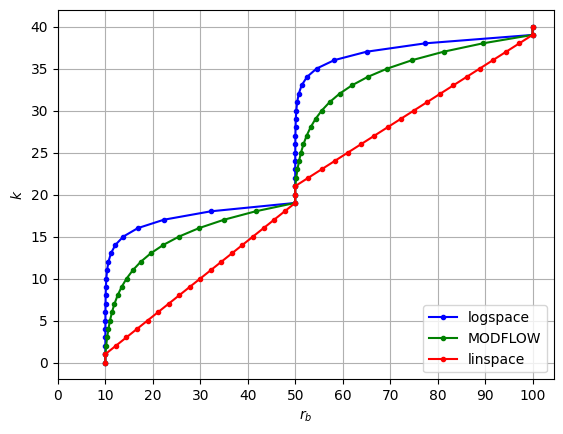

In [ ]:
k = np.arange(len(rb1))
plt.plot(rb2, k, 'b.-');
plt.plot(rb3, k, 'g.-');
plt.plot(rb1, k, 'r.-');
plt.grid();
plt.ylabel('$k$');
plt.gca().set_yticks(np.arange(0, 45, 5))
plt.gca().set_xticks(np.arange(0, 110, 10))
plt.xlabel('$r_b$');
plt.legend(['logspace', 'MODFLOW', 'linspace'], loc='lower right');

## Verification

### Circular infiltration area

Dimensionless parameter example (Section 5.5.1.3):

In [ ]:
# analytical solution (Bakker & Strack, 2003)
R = np.array([0.001, 1, 100])  # R/L with L = sqrt(Ttot*ctot)
r = np.logspace(np.log10(R[0]), np.log10(R[-1]), 100)  # r/L
T = np.array([0.5, 0.2, 0.3])  # T/Ttot
c = np.array([0.2, 0.8])  # c/ctot
N = -0.1  # N*T*c/Qtot
Q = np.array([0, 0.1, 0.9])  # Q/Qtot

# calculate dimensionless drawdown s*Ttot/Qtot
s1 = bakker_strack_1layer(r=r, R=R[1], r_out=R[-1], T=T.sum(), Q=Q.sum(), N=N)
s2 = bakker_strack_2layers(r=r, R=R[1], r_out=R[-1], T=[T[0], T[1:].sum()], c=c[0], Q=[Q[0], Q[1:].sum()], N=N)
s3 = bakker_strack(r=r, R=R[1], r_out=R[-1], T=T, c=c, Q=Q, N=N)

In [ ]:
# generalized semi-analytical multilayer-multizone solution (Louwyck, 2023)
TT = np.vstack((T, T)).T
cc = np.vstack((c, c)).T
ccc = np.inf * np.ones((len(T)+1, 2))
ccc[1:-1, :] = cc
NN = np.zeros((len(T), 2))
NN[0, 0] = N

# 1 layer
ana1 = Steady(R=R, T=TT.sum(axis=0, keepdims=True), Q=Q.sum(), N=NN.sum(axis=0, keepdims=True),
              c=ccc[[0, -1], :])
ana1.use_scipy_solver = True  # confined + steady -> singular system matrices

# 2 layers
ana2 = Steady(R=R, Q=[Q[0], Q[1:].sum()],
              T=np.vstack((TT[[0], :], TT[1:, :].sum(axis=0, keepdims=True))),
              N=np.vstack((NN[[0], :], NN[1:, :].sum(axis=0, keepdims=True))),
              c=np.vstack((ccc[[0], :], cc[[0], :], ccc[[-1], :])))
ana2.use_scipy_solver = True  # confined + steady -> singular system matrices

# 3 layers
ana3 = Steady(R=R, T=TT, c=ccc, Q=Q, N=NN)
ana3.use_scipy_solver = True  # confined + steady -> singular system matrices

In [ ]:
# finite-difference solution (Louwyck et al., 2012)
num1 = Steady2Numerical(ana1)
num1.solve()
num2 = Steady2Numerical(ana2)
num2.solve()
num3 = Steady2Numerical(ana3)
num3.solve()

Creating Figure 3:

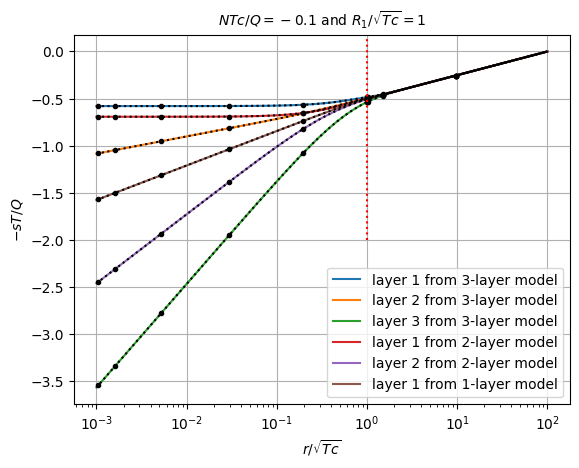

In [ ]:
plt.semilogx(r, -s3.T, '-');
plt.semilogx(r, -s2.T, '-');
plt.semilogx(r, -s1, '-');
plt.legend(['layer 1 from 3-layer model', 'layer 2 from 3-layer model', 'layer 3 from 3-layer model',
            'layer 1 from 2-layer model', 'layer 2 from 2-layer model', 'layer 1 from 1-layer model'])

plt.semilogx(r, -ana1.h(r).squeeze(), 'k:');
plt.semilogx(r, -ana2.h(r).T, 'k:');
plt.semilogx(r, -ana3.h(r).T, 'k:');

n = 10
plt.semilogx(num1.r[::n], -num1.h[0, ::n], 'k.');
plt.semilogx(num2.r[::n], -num2.h[:, ::n].T, 'k.');
plt.semilogx(num3.r[::n], -num3.h[:, ::n].T, 'k.');

yl = plt.gca().get_ylim()
plt.semilogx(R[[1, 1]], [-2, yl[1]], 'r:');
plt.ylim(yl);

plt.grid();
plt.title('$NTc/Q=-0.1$ and $R_1/\sqrt{Tc} = 1$', dict(fontsize=10));
plt.xlabel('$r/\sqrt{Tc}$');
plt.ylabel('$-sT/Q$');

### Formula of Blom

Dimensionless parameter example (Section 5.5.2.3):

In [ ]:
# input parameters
r = np.logspace(-3, 3, 100)  # r/L with L = sqrt(T*c)
R = 1.25  # R/L
Ns = [0.01, 0.1, 1]  # NL²/Q
Q = -1
T = 1
c = 1

In [ ]:
czone = np.inf * np.ones((2, 2))
czone[0, -1] = c
s, h, hnum = [], [], []
for N in Ns:
    s.append(blom(r, R, T, c, Q, N))  # sT/Q according to Blom (1973)
    m = Steady([0, R, np.inf], [[T, T]], c=czone, Q=[Q], N=[[N, 0]], axi=True)
    h.append(m.h(r).squeeze())
    num = Steady2Numerical(m)
    num.solve()
    b = (num.r >= r[0]) & (num.r <= r[-1])
    hnum.append(num.h[-1, b])

Creating Figure 4:

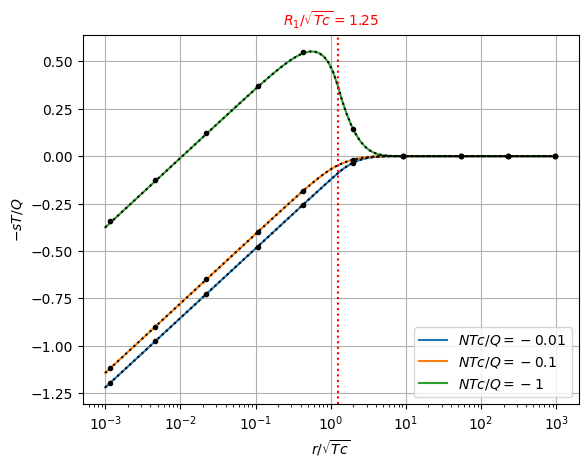

In [ ]:
plt.semilogx(r, np.array(s).T, '-');
plt.legend(['$NTc/Q=-' + str(N) + '$' for N in Ns], loc='lower right');
plt.semilogx(r, np.array(h).T, 'k:');
i = select_points(np.logspace(-3, 3, 10), num.r[b])
plt.semilogx(num.r[b][i], np.array(hnum)[:, i].T, 'k.');
yl = plt.gca().get_ylim()
plt.semilogx([R, R], yl, 'r:');
plt.ylim(yl);
plt.grid();
plt.title('$R_1/\sqrt{Tc}=1.25$', dict(fontsize=10, color='red'));
plt.xlabel('$r/\sqrt{Tc}$');
plt.ylabel('$-sT/Q$');

### Steady-state confined one-layer solutions

Dimensionless parameter example (Section 5.5.3.4):

In [ ]:
# input parameters
R = np.logspace(0, 4, 5)  # R/R0
T = np.array([0.1, 0.4, 0.2, 0.3])  # T/Ttot
Q = 1
h_out = 1
r = np.logspace(0, 4, 1000)  # r/R0

In [ ]:
# Q given

# analytical solution (Louwyck, 2023)
hQ = multizone_steadyQ(r=r, R=R, T=T, Q=Q, h_out=h_out)  # h*Ttot/Q (scenario 1)
hQrev = multizone_steadyQ(r=r, R=R, T=T[::-1], Q=Q, h_out=h_out)  # reversed T (scenario 2)

# generalized semi-analytical solution (Louwyck, 2023)
anaQ = Steady(R=R, T=[T], c=np.inf*np.ones((2, len(T))), Q=[Q], h0=h_out*np.ones((3, len(T))))
anaQ.use_scipy_solver = True  # confined + steady -> singular system matrices
anaQ_rev = Steady(R=R, T=[T[::-1]], c=np.inf*np.ones((2, len(T))), Q=[Q], h0=h_out*np.ones((3, len(T))))
anaQ_rev.use_scipy_solver = True  # confined + steady -> singular system matrices

# finite-difference solution (Louwyck et al., 2012)
numQ = Steady2Numerical(anaQ)
numQ.solve()
numQ_rev = Steady2Numerical(anaQ_rev)
numQ_rev.solve()

In [ ]:
# H given
H = hQ[0]  # get H from Q model

# analytical solution (Louwyck, 2023)
hH = multizone_steadyH(r=r, R=R, T=T, H=H, h_out=h_out)  # h*Ttot/Q (scenario 1)
hHrev = multizone_steadyH(r=r, R=R, T=T[::-1], H=H, h_out=h_out)  # reversed T (scenario 2)

# generalized semi-analytical solution (Louwyck, 2023)
anaH = Steady(R=R, T=[T], c=np.inf*np.ones((2, len(T))), H=[H], h0=h_out*np.ones((3, len(T))))
anaH.use_scipy_solver = True  # confined + steady -> singular system matrices
anaH_rev = Steady(R=R, T=[T[::-1]], c=np.inf*np.ones((2, len(T))), H=[H], h0=h_out*np.ones((3, len(T))))
anaH_rev.use_scipy_solver = True  # confined + steady -> singular system matrices

# finite-difference solution (Louwyck et al., 2012)
numH = Steady2Numerical(anaH)
numH.solve()
numH_rev = Steady2Numerical(anaH_rev)
numH_rev.solve()

In [ ]:
# solutions for the equivalent one-zone model with effective transmissivity (Louwyck, 2023)
Teq = np.log(R[-1]/R[0]) / np.sum(np.log(R[1:]/R[:-1]) / T)
print(f"Effective T is {Teq}")

hQ_eq = h_out - Q/2/np.pi/Teq * np.log(r/R[-1])  # Q given
hH_eq = (H * np.log(r/R[-1]) + h_out * np.log(R[0]/r)) / np.log(R[0]/R[-1])  # H given

Effective T is 0.192


Creating Figure 5:

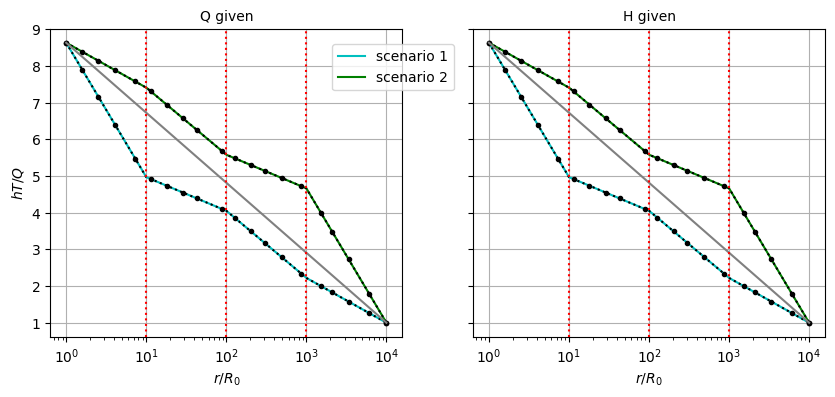

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.semilogx(r, hQ, 'c-');
ax1.semilogx(r, hQrev, 'g-');
ax1.legend(['scenario 1', 'scenario 2'], loc=(0.8, 0.8));  # 'upper right'
ax1.semilogx(r, anaQ.h(r).squeeze(), 'k:');
ax1.semilogx(r, anaQ_rev.h(r).squeeze(), 'k:');
i = select_points(np.logspace(0, 4, 20), numQ.r)
ax1.semilogx(numQ.r[i], numQ.h[0, i], 'k.');
ax1.semilogx(numQ_rev.r[i], numQ_rev.h[0, i], 'k.');
ax1.semilogx(r, hQ_eq, 'gray');
yl = ax1.get_ylim()
ax1.plot(np.vstack((R[1:-1], R[1:-1])), yl, 'r:');
ax1.set_ylim(yl);
ax1.set_title('Q given', dict(fontsize=10));
ax1.grid();
ax1.set_xlabel('$r/R_0$');
ax1.set_ylabel('$hT/Q$');

ax2.semilogx(r, hH, 'c-');
ax2.semilogx(r, hHrev, 'g-');
ax2.semilogx(r, anaH.h(r).squeeze(), 'k:');
ax2.semilogx(r, anaH_rev.h(r).squeeze(), 'k:');
i = select_points(np.logspace(0, 4, 20), numH.r)
ax2.semilogx(numH.r[i], numH.h[0, i], 'k.');
ax2.semilogx(numH_rev.r[i], numH_rev.h[0, i], 'k.');
ax2.semilogx(r, hH_eq, 'gray');
yl = ax2.get_ylim()
ax2.plot(np.vstack((R[1:-1], R[1:-1])), yl, 'r:');
ax2.set_ylim(yl);
ax2.set_title('H given', dict(fontsize=10));
ax2.grid();
ax2.set_xlabel('$r/R_0$');

### Steady-state leaky one-layer solution

Dimensionless parameter example (Section 5.5.4.3):

In [ ]:
# input parameters
R = np.array([0.01, 0.05])  # R/sqrt(Ttot*ctot)
Ts = np.array([[1/11, 10/11], [0.5, 0.5], [10/11, 1/11]])  # T/Ttot
c = np.array([0.5, 0.5])  # c/ctot
Q = 1
r = np.logspace(np.log10(R[0]), np.log10(2), 100)  # r/sqrt(Ttot*ctot)

In [ ]:
# simulations
s = []
sa = []
h = []
hnum = []
for T in Ts:
    print(T)
    s.append(deglee_skin(r=r, R=R, T=T, c=c, Q=Q))  # s*Ttot/Q (Louwyck, 2023)
    sa.append(deglee_skin_approximate(r=r, R=R[1], T=T, c=c, Q=Q))  # approximation (Louwyck, 2023)
    m = Steady(R=[R[0], R[1], np.inf], T=[T], c=np.vstack((c, c)).T, Q=[Q])  # semi-analytic (Louwyck, 2023)
    h.append(m.h(r)[0])
    num = Steady2Numerical(m)
    num.solve()  # finite-difference (Louwyck et al., 2012)
    hnum.append(num.h[1])

[0.09090909 0.90909091]
[6.63324958 2.0976177 ]
[0.5 0.5]
[2.82842712 2.82842712]
[0.90909091 0.09090909]
[2.0976177  6.63324958]


Creating Figure 6:

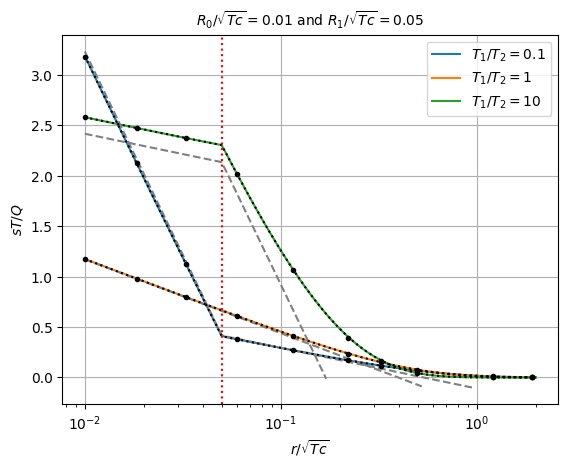

In [ ]:
plt.semilogx(r, np.array(s).T, '-');
plt.legend(['$T_1/T_2 = 0.1$', '$T_1/T_2 = 1$', '$T_1/T_2 = 10$']);
sa = np.array(sa).T
sa[sa<-0.1] = np.nan
plt.semilogx(r, sa, color='gray', linestyle='--');
plt.semilogx(r, np.array(h).T, 'k:');
i = select_points(np.logspace(np.log10(R[0]), np.log10(2), 10), num.r)
plt.semilogx(num.r[i], np.array(hnum)[:, i].T, 'k.')
yl = plt.gca().get_ylim()
plt.semilogx(R[[1, 1]], yl, 'r:');
plt.ylim(yl);
plt.xlabel('$r/\sqrt{Tc}$');
plt.ylabel('$sT/Q$');
plt.title('$R_0/\sqrt{Tc} = 0.01$ and $R_1/\sqrt{Tc} = 0.05$', dict(fontsize=10));
plt.grid();

### Transient state confined one-layer solution

Dimensionless parameter example (Section 5.5.5.3):

In [ ]:
# input parameters
R = 1
r = np.logspace(-2, 3, 100)  # r/R
t = np.logspace(-2, 3, 6)  # tT/R²/S
T = np.array([10/11, 1/11])
S = np.array([1/11, 10/11])
Q = 1

In [ ]:
# simulations
s = butler(r=r, t=t, R=R, T=T, S=S, Q=Q, ns=10)  # sT/Q (Butler, 1988)
sa = barker_herbert(r=r, t=t[-2:], R=R, T=T, S=S, Q=Q)  # late-time approximation (Barker & Herbert, 1982)
sa[sa < -0.1] = np.nan
ana = Transient(R=[0, R, np.inf], T=[T], S=[S], c=np.inf*np.ones((2, 2)), Q=[Q])  # semi-analytic (Louwyck, 2023)
num = Transient2Numerical(ana, t=np.logspace(-5, 3, 500))
num.solve()  # finite-difference (Louwyck et al., 2012)

Creating Figure 7:

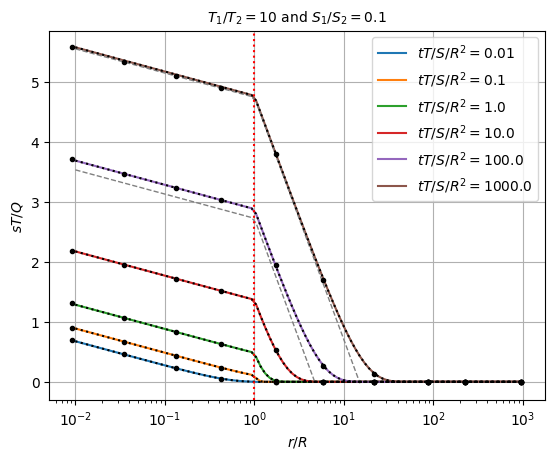

In [ ]:
plt.semilogx(r, s, '-');
plt.legend([('$tT/S/R^2=' + str(t) + '$') for t in t])
plt.semilogx(r, sa, color='gray', linestyle='--', linewidth=1);
plt.semilogx(r, ana.h(r, t)[0], 'k:')
i = select_points(np.logspace(-2, 3, 10), num.r)
k = select_points(t, num.t)
plt.semilogx(num.r[i], num.h[0][i][:, k], 'k.');
yl = plt.gca().get_ylim()
plt.plot([R, R], yl, 'r:');
plt.xlabel('$r/R$');
plt.ylabel('$sT/Q$');
plt.title('$T_1/T_2=10$ and $S_1/S_2=0.1$', dict(fontsize=10));
plt.ylim(yl);
plt.grid();

### Slug test in confined aquifer

Dimensionless parameter example (Section 5.5.6.3):

In [ ]:
# input parameters
rw = rc = 1
T = 1
S_list = np.logspace(-5, -1, 5)  # alpha = S*rw**2/rc**2
t = np.logspace(-5, 3, 100)  # tT/rc**2
y0 = 1

In [ ]:
# simulations

R = [0, rw, np.inf]
c = np.inf*np.ones((2, 2))
h0 = np.zeros((3, 2))
h0[1, 0] = y0

h = []
ha = []
hn = []
for S in S_list:
    h.append(cooper(rc=rc, rw=rw, y0=y0, T=T, S=S, t=t))  # h/y0 (Cooper et al., 1967)
    ana = Transient(R=R, T=[[1e5, T]], S=[[1, S]], c=c, Q=[0], h0=h0)  # semi-analytic (Louwyck, 2023)
    ana.use_scipy_solver = False
    ha.append(ana.h([rw], t).squeeze())
    num = Transient2Numerical(ana, t=t)
    num.solve()  # finite-difference (Louwyck et al., 2012)
    hn.append(num.h[0, 0, :])

Creating Figure 8:

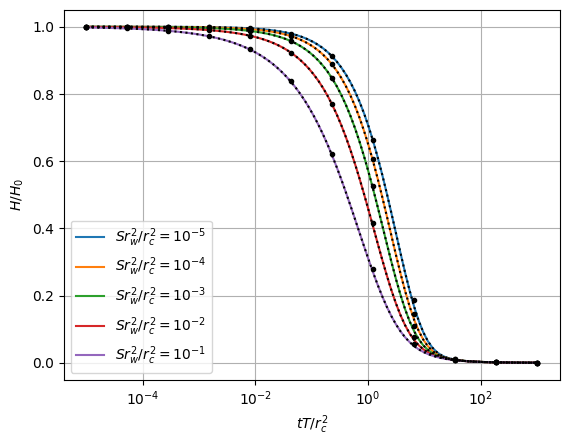

In [ ]:
plt.semilogx(t, np.array(h).T, '-');
plt.legend(['$Sr_w^2/r_c^2=10^{' + str(int(np.log10(S))) + '}$' for S in S_list], loc='lower left');
plt.semilogx(t, np.array(ha).T, 'k:');
k = select_points(np.logspace(-5, 3, 12), num.t)
plt.semilogx(num.t[k], np.array(hn)[:, k].T, 'k.');
plt.xlabel('$tT/r_c^2$');
plt.ylabel('$H/H_0$');
plt.grid();

### Embanked river infiltrating a multilayer aquifer system

Example (Section 5.5.7) - simulations without dike:

In [ ]:
# semi-analytical solution (Louwyck, 2023)
R = np.array([0, 0.001, 10, 30, 500, 1e6])
T = np.array([[1e5,  1e5, 20,  20,  20 ],
              [1e-5, 100, 100, 100, 100],
              [1e-5, 10,  10,  10,  10 ],
              [1e-5, 50,  50,  50,  50 ]])
c = np.array([[np.inf, np.inf, 10,  10,  np.inf],
              [10,     10,     10,  10,  10    ],
              [200,    200,    200, 200, 200   ],
              [300,    300,    300, 300, 300   ],
              [500,    500,    500, 500, 500   ]])
N = np.zeros((4, 5))
N[0, -2:] = 0.1 / 365
H = np.array([1, 0, 0, 0])
ana = Steady(R=R, T=T, c=c, H=H, N=N, axi=False)

# finite-difference solution (Louwyck et al., 2012)
h0 = np.zeros((6, 5))
h0[1:-1, 0] = H
out = discretize(R=R, T=T, c=c, h0=h0, N=N[0], axi=False)
nr, nl = len(out['rb']) - 1, len(H)
TT, QQ, cst = np.zeros((nl+2, nr)),  np.zeros((nl+2, nr)), np.zeros((nl+2, nr))
TT[1:-1, :] = out['T']
QQ[1, :] += out['N']
cst[[0, -1], :] = 1
cst[:, [0, -1]] = 1
num = Numerical(rb=out['rb'], T=TT, c=out['c'], h0=out['h0'], Q=QQ, constant=cst, axi=False)
num.solve()

Example (Section 5.5.7) - simulation with homogeneous layers (Hemker, 1984):

In [ ]:
# semi-analytical solution (Hemker, 1984)
m = Steady(R=R[[2, -1]], T=T[:, [3]], c=c[:, [3]], Q=[1, 0, 0, 0], axi=False)
r = np.logspace(np.log10(m.R[0]), np.log10(num.r[-1]), 100)
h = m.h(r).T
h /= h[0, 0]

Example (Section 5.5.7) - simulations with dike:

In [ ]:
from copy import deepcopy
T2 = T.copy()
T2[0, 2] = 1e-3
c2 = c.copy()
c2[0, :3] = np.inf
ana2 = Steady(R=R, T=T2, c=c2, H=H, N=N, axi=False)
num2 = deepcopy(num)
out2 = discretize(R=R, T=T2, c=c2, h0=h0, axi=False)
TT2 = np.zeros((nl+2, nr))
TT2[1:-1, :] = out2['T']
num2.T = TT2
num2.c = out2['c']
num2.solve()

Creating Figure 11:

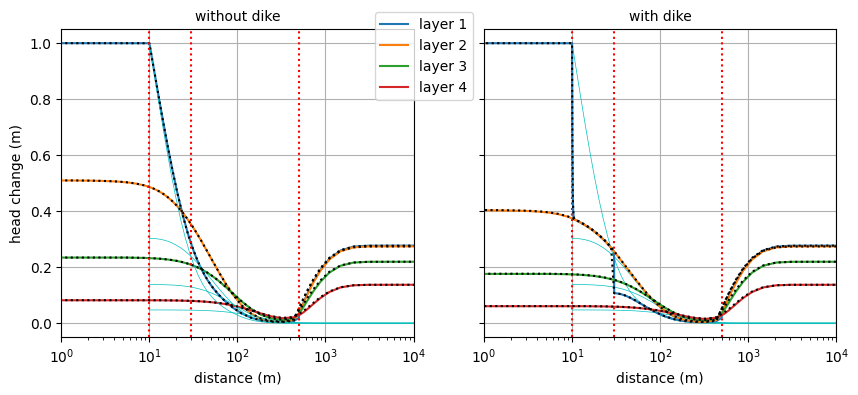

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.semilogx(num.r, ana.h(num.r).T, '-');
ax1.legend(['layer ' + str(i) for i in range(1, nl+1)], loc=(0.89, 0.77))
ax1.semilogx(r, h, color='c', linewidth=0.5);
ax1.semilogx(num.r, num.h[1:-1, :].T, 'k:');
yl = ax1.get_ylim()
ax1.semilogx(np.tile(R[2:-1],(2, 1)), yl, 'r:')
ax1.set_xlim((1, 1e4))
ax1.set_ylim(yl)
ax1.grid();
ax1.set_title('without dike', dict(fontsize=10));
ax1.set_xlabel('distance (m)');
ax1.set_ylabel('head change (m)');

ax2.semilogx(np.tile(R[2:-1],(2, 1)), yl, 'r:')
ax2.semilogx(r, h, color='c', linewidth=0.5);
ax2.semilogx(num2.r, ana2.h(num2.r).T, '-');
ax2.semilogx(num2.r, num2.h[1:-1, :].T, 'k:');
ax2.set_xlim((1, 1e4))
ax2.set_ylim(yl)
ax2.grid();
ax2.set_title('with dike', dict(fontsize=10));
ax2.set_xlabel('distance (m)');

## Skin effect

### Skin effect in case of transient flow

Dimensionless parameter example of a confined aquifer (Section 5.6.4):

In [ ]:
# input parameters
R = 1
r = np.logspace(-1, 2, 100)  # r/R
t = np.logspace(0, 4, 5)  # tT/R²/S
T = np.array([10/11, 1/11])
S = np.array([1/11, 10/11])
Q = 1

In [ ]:
# simulations (Louwyck, 2023)
ana = Transient(R=[0, R, np.inf], T=[T], S=[S], c=np.inf*np.ones((2, 2)), Q=[Q])
uni = Transient(R=[0, np.inf], T=[[T[-1]]], S=[[S[-1]]], c=np.inf*np.ones((2, 1)), Q=[Q])
print('F = ', F([r[0], R], T))
print('well loss = ', well_loss(Q, [r[0], R], T))
h = uni.h([R], t).squeeze() + well_loss(Q, [r[0], R], T)

F =  0.23025850929940458
well loss =  0.4031145793836853


Creating Figure 13:

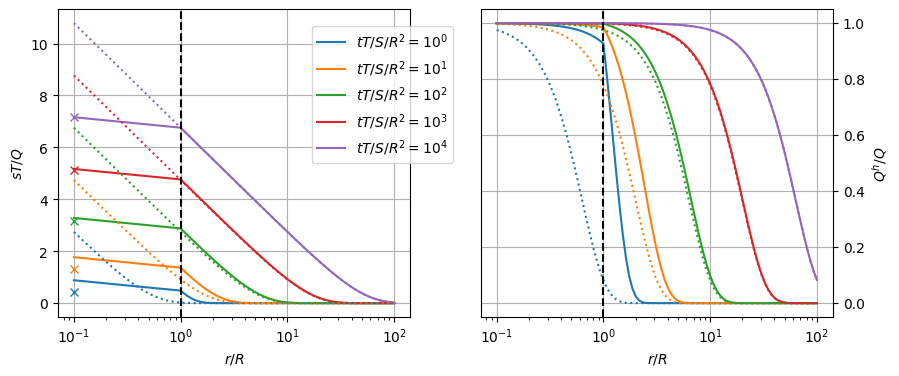

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

lines = ax1.semilogx(r, ana.h(r, t)[0], '-');
lines_uni = ax1.semilogx(r, uni.h(r, t)[0], ':');
ax1.legend([('$tT/S/R^2=10^' + str(int(np.log10(t))) + '$') for t in t], loc=(0.72, 0.5))
for i, line in enumerate(lines):
    ax1.semilogx(r[0], h[i], 'x', color=line.get_color())
    lines_uni[i].set_color(line.get_color())
yl = ax1.get_ylim()
ax1.plot([R, R], yl, 'k--');
ax1.set_xlabel('$r/R$');
ax1.set_ylabel('$sT/Q$');
ax1.set_ylim(yl);
ax1.grid();

lines = ax2.semilogx(r, -ana.qr(r, t)[0], '-');
lines_uni = ax2.semilogx(r, -uni.qr(r, t)[0], ':');
for i, line in enumerate(lines):
    lines_uni[i].set_color(line.get_color())
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
yl = ax2.get_ylim()
ax2.plot([R, R], yl, 'k--');
ax2.set_xlabel('$r/R$');
ax2.set_ylabel('$Q^h/Q$');
ax2.set_ylim(yl);
ax2.grid();

### Skin effect for a well in a multilayer system

Dimenionless parameter example of a leaky aquifer (Section 5.6.5):

In [ ]:
# input parameters
Rs = np.array([[0.01, 0.02],
               [0.01, 0.05],
               [0.01, 0.10],
               [0.01, 0.20],
               [0.01, 0.50]])  # R/sqrt(Ttot*ctot)
Ts = np.array([[1/11, 10/11]])  # T/Ttot
T = np.array([1/11, 10/11])  # T/Ttot
c = np.array([0.5, 0.5])  # c/ctot
Q = 1
r = np.logspace(np.log10(Rs[0, 0] + 1e-5), np.log10(3), 100)  # r/sqrt(Ttot*ctot)

In [ ]:
# simulations (Louwyck, 2023)
h = []
qr = []
s = []
uni = Steady(R=[Rs[0, 0], np.inf], T=[[T[-1]]], c=c[:, np.newaxis], Q=[Q])
for R in Rs:
    print(R[-1])
    print(F(R, T))
    print(well_loss(Q, R, T))
    print()
    m = Steady(R=[R[0], R[1], np.inf], T=[T], c=np.vstack((c, c)).T, Q=[Q])
    h.append(m.h(r)[0])
    qr.append(m.qr(r)[0])
    s.append((uni.h(R[[1]]).squeeze() + well_loss(Q, R, T)))

0.02
6.931471805599452
1.2134958008395837

0.05
16.094379124341003
2.817649992997269

0.1
23.025850929940457
4.031145793836853

0.2
29.95732273553991
5.244641594676437

0.5
39.12023005428146
6.848795786834121



Creating Figure 14:

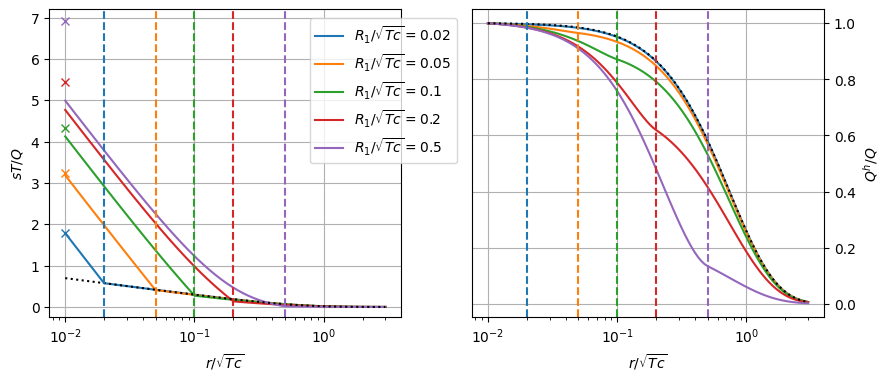

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

lines = ax1.semilogx(r, np.array(h).T, '-');
ax1.legend(['$R_1/\sqrt{Tc} = ' + str(R[-1]) + '$' for R in Rs], loc=(0.74, 0.5));
ax1.semilogx(r, uni.h(r)[0].T, 'k:');
yl = list(ax1.get_ylim())
yl[-1] = 7.2
for i, line in enumerate(lines):
    ax1.semilogx(R[0], s[i], 'x', color=line.get_color());
    ax1.semilogx(Rs[i][[-1, -1]], yl, color=line.get_color(), linestyle='--');
ax1.set_ylim(yl);
ax1.set_xlabel('$r/\sqrt{Tc}$');
ax1.set_ylabel('$sT/Q$');
ax1.grid();

lines = ax2.semilogx(r, -np.array(qr).T, '-');
ax2.semilogx(r, -uni.qr(r)[0].T, 'k:');
yl = ax2.get_ylim();
for i, line in enumerate(lines):
    ax2.semilogx(Rs[i][[-1, -1]], yl, color=line.get_color(), linestyle='--');
ax2.set_ylim(yl);
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");
ax2.set_xlabel('$r/\sqrt{Tc}$');
ax2.set_ylabel('$Q^h/Q$');
ax2.grid();

## References

- Bakker, M., & Strack, O. D. L. (2003). Analytic elements for multiaquifer flow. Journal of Hydrology, 271(1–4). https://doi.org/10.1016/S0022-1694(02)00319-0

- Barker, J. A., & Herbert, R. (1982). Pumping Tests in Patchy Aquifers. Ground Water, 20(2), 150–155. https://doi.org/10.1111/j.1745-6584.1982.tb02742.x

- Blom, J. (1973). Verlagingen van het freatisch vlak bij grondwateronttrekking in een gebied met vrije afwatering (Drenthe) (in Dutch). RID Mededeling 74-7, Rijksinstituut voor Drinkwatervoorziening (RID), The Netherlands.

- Bruggeman, G. A. (1999). Analytical solutions of geohydrological problems. Developments in Water Science 46. Amsterdam: Elsevier.

- Butler, J. J. (1988). Pumping tests in nonuniform aquifers — The radially symmetric case. Journal of Hydrology, 101(1–4), 15–30. https://doi.org/10.1016/0022-1694(88)90025-X

- Cooper, H. H., Bredehoeft, J. D., & Papadopulos, I. S. (1967). Response of a finite-diameter well to an instantaneous charge of water. Water Resources Research, 3(1), 263–269. https://doi.org/10.1029/WR003i001p00263

- de Glee, G. J. (1930). Over grondwaterstroomingen bij wateronttrekking door middel van putten (in Dutch) (PhD thesis). Technische Hoogeschool Delft, Drukkerij J. Waltman. Jr., Delft. http://resolver.tudelft.nl/uuid:c3e13209-4626-41b9-9038-c223d61e35c4

- Hemker, C. J. (1984). Steady groundwater flow in leaky multiple-aquifer systems. Journal of Hydrology, 72(3–4), 355–374. https://doi.org/10.1016/0022-1694(84)90089-1

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Louwyck, A., Vandenbohede, A., Bakker, M., & Lebbe, L. C. (2012). Simulation of axi-symmetric flow towards wells: A finite-difference approach. Computers & Geosciences, 44, 136–145. https://doi.org/10.1016/j.cageo.2011.09.004

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47–49. https://doi.org/10.1145/361953.361969


---